#### Importing Libraries and Packages

In [1]:
import pandas as pd
import glob
import json
import numpy as np
import scipy.stats as stats
import re
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.corpus import stopwords


#### Reading all JSON files and putting into Data Frame

In [2]:
df = pd.DataFrame()
read_files = glob.glob("tablets/*.json")
for i in range(0,len(read_files)):
    with open(read_files[i], 'rb') as x:
        JSONFILE = json.load(x)
    review_df = pd.DataFrame(JSONFILE['Reviews'])
    product = JSONFILE['ProductInfo']
    combined_df = pd.concat([review_df, pd.DataFrame(product, index=review_df.index)], axis=1)
    df = pd.concat([df, combined_df])

df.head()

,Author,Content,Date,Features,ImgURL,Name,Overall,Price,ProductID,ReviewID,Title
0,janice s.,My DeerBrook tablet powered right up out of th...,"May 30, 2014",None,None,None,5.0,None,B00IQWNOZW,R240SJQ9XLDI9A,Great Tablet for the Price!!
1,Jonathan Orlofsky,"I chose this product, because the identical li...","April 15, 2014",None,None,None,1.0,None,B00IQWNOZW,R3FDD14C4LWFZE,"POS - Lied to by company, will never purchase ..."
2,liza,First of all I didn't think it could be very s...,"March 12, 2014",None,None,None,4.0,None,B00IQWNOZW,R3PMTJJUNPDOQ2,How does it charge
0,rpv,<!--\n\nfunction fp_resizePlayerSpace(nsPrefix...,"March 5, 2014",CPU: Cortex A8 Dual Core 1.2Ghz\n7-Inch Capaci...,http://ecx.images-amazon.com/images/I/51aYmaSz...,"ProntoTec 7"" Android 4.2 Tablet PC, Cortex A8 ...",5.0,$109.98,B00GMDAAE0,R5XZELEP73F9G,Excellent Value/Budget Tablet
1,KPAk,I bought seven of these based on the ratings. ...,"April 25, 2014",CPU: Cortex A8 Dual Core 1.2Ghz\n7-Inch Capaci...,http://ecx.images-amazon.com/images/I/51aYmaSz...,"ProntoTec 7"" Android 4.2 Tablet PC, Cortex A8 ...",5.0,$109.98,B00GMDAAE0,R5X32PK6LNFXT,Affordable!


#### Removing Null values and missing Values

In [3]:
df = df.mask(df['Date'].eq('None')).dropna()
df = df.loc[~df.Name.isnull()]
df = df.reset_index()

#### Extracting the Make

In [4]:
def find_make(x):
    
    if x[0].isnumeric():
        if x.split()[1] == 'dual':
            return 'Google'
        else:
            return x.split()[1]
    else:
        return x.split()[0]

In [5]:
df['Make'] = df.Name.apply(lambda x: find_make(x))

#### Removing Special characters, Stop Words

In [6]:
def clean_review(x):
    stp = stopwords.words('english')
   
    if x.startswith('<!'):
        idx = x.find('Mins') + 4
        x = x[idx:]
        
    
    x = x.replace('\n', ' ')
    x = re.sub('\s+', ' ', x)
    
    
    x = re.sub('[^a-zA-Z\s]+', ' ', x)
    
    
    x = [x.lower() for x in x.split()]
    
    
    filtered = [word for word in x if word not in stp]
    
    return ' '.join(filtered)

In [7]:
df['Review'] = df.Content.apply(lambda x: clean_review(x))

#### Finding the Sentiment Polarity

In [8]:
def find_sentiment(x):
    review = TextBlob(x)
    sent = review.sentiment.polarity
    if sent > 0:
        return 'positive'
    elif sent < 0:
        return 'negative'
    else:
        return 'neutral'

In [9]:
df['Sentiment'] = df.Review.apply(lambda x: find_sentiment(x))

In [10]:
pos_reviews = df.loc[df.Sentiment=='positive']['Review'].values.tolist()
neg_reviews = df.loc[df.Sentiment=='negative']['Review'].values.tolist()

#### Getting the Word Count

In [11]:
def find_word_counts(reviews):
    counts = {}
    for review in reviews:
        for word in review.split():
            if word in counts.keys():
                counts[word] += 1
            else:
                counts[word] = 1
    data = list(zip(counts.keys(), counts.values()))
    df = pd.DataFrame(data, columns=['Word', 'Count'])
    return df.sort_values(by='Count', ascending=False)

#### Seperating Positive and Negative Word Counts

In [14]:
pos_counts_df = find_word_counts(pos_reviews)
neg_counts_df = find_word_counts(neg_reviews)

#### Filter Common words in both Postive and Negative

In [15]:

pos_words = set(pos_counts_df.Word.tolist())
neg_words = set(neg_counts_df.Word.tolist())

pos_filter = pos_words - neg_words
neg_filter = neg_words - pos_words

pos_counts_df = pos_counts_df.loc[pos_counts_df.Word.isin(pos_filter)]
neg_counts_df = neg_counts_df.loc[neg_counts_df.Word.isin(neg_filter)]

#### Calculating top Positive and Negative words

In [16]:

top_pos = pos_counts_df.iloc[:10]
top_neg = neg_counts_df.iloc[:10]

#### Graph for Positive and Negative Words

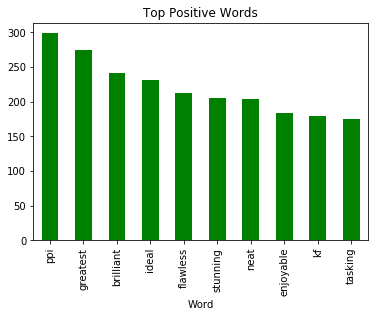

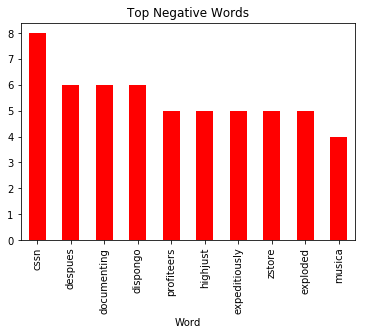

In [17]:

top_pos.plot(kind='bar', x='Word', color='green', title='Top Positive Words', legend=False)
plt.show()

top_neg.plot(kind='bar', x='Word', color='red', title='Top Negative Words', legend=False)
plt.show()

#### Combining all the above, getting Positive and Negative by Make and Plotting the Graph

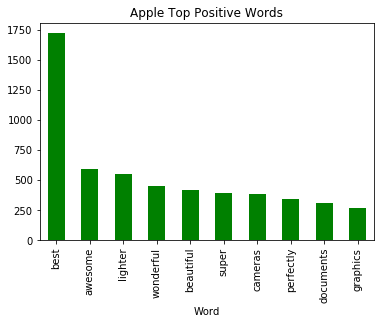

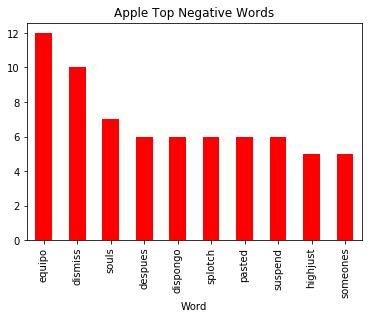

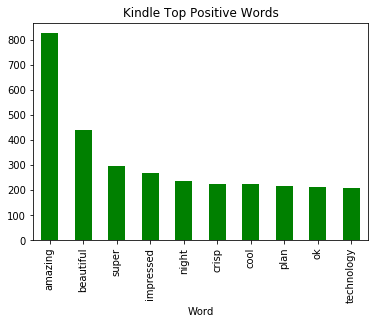

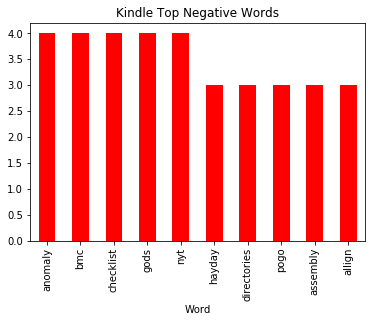

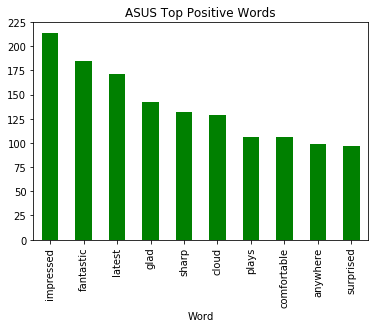

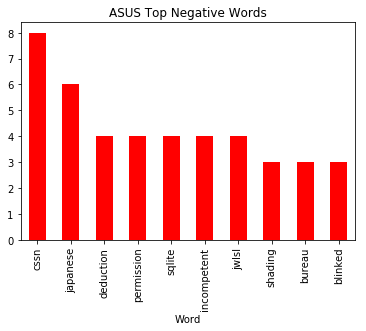

In [18]:

top_words = []
top_makes = df.Make.value_counts()[:3].index.tolist()
for make_type in top_makes:
    make_df = df.loc[df.Make==make_type]
    
    
    pos_reviews = make_df.loc[make_df.Sentiment=='positive']['Review'].values.tolist()
    neg_reviews = make_df.loc[make_df.Sentiment=='negative']['Review'].values.tolist()
    
    
    pos_counts_df = find_word_counts(pos_reviews)
    neg_counts_df = find_word_counts(neg_reviews)
    
    
    pos_words = set(pos_counts_df.Word.tolist())
    neg_words = set(neg_counts_df.Word.tolist())
    pos_filter = pos_words - neg_words
    neg_filter = neg_words - pos_words
    pos_counts_df = pos_counts_df.loc[pos_counts_df.Word.isin(pos_filter)]
    neg_counts_df = neg_counts_df.loc[neg_counts_df.Word.isin(neg_filter)]
    
    
    top_pos = pos_counts_df.iloc[:10]
    top_neg = neg_counts_df.iloc[:10]
    
    
    top_words.append([make_type, top_pos.iloc[0].Word, top_pos.iloc[0].Count])
    
    # Plot
    pos_title = '{} Top Positive Words'.format(make_type)
    top_pos.plot(kind='bar', x='Word', title=pos_title, color='green', legend=False)
    plt.show()
    neg_title = '{} Top Negative Words'.format(make_type)
    top_neg.plot(kind='bar', x='Word', title=neg_title, color='red', legend=False)
    plt.show()

#### Plot for Top words in each Make

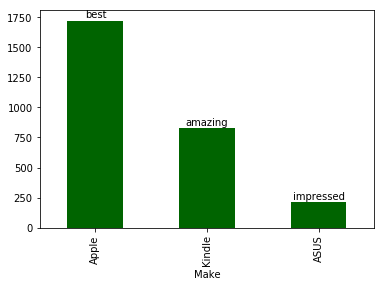

In [19]:
# Plot top word for each make
df_data = [ (x[0], x[2]) for x in top_words]
labels = [x[1] for x in top_words]
top_words_df = pd.DataFrame(df_data, columns=['Make', 'Top Word'])

ax = top_words_df.plot(kind='bar', x='Make', color='darkgreen', legend=False)
rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()